In [9]:
# Imports
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torch.nn.functional as F

cuda = torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io
import sys
sys.path.append("../../semi-supervised")

# Deep Generative Model

In this notebook we show how you can use the deep "generative model for semi-supervised learning" as presented in [[Kingma 2014]](https://arxiv.org/abs/1406.5298). The paper posits three different models, though we are just interested in two of these: the M2 model and the M1+M2 model.

The M1 model is just a variational autoencoder, so we refer to the previous notebook for more information on this. The M2 model however is an extension to the VAE to include label information for a semi-supervised objective. The structure is shown below (left: inference model, right: generative model).

<img src="../images/dgm.png" width="400px"/>

The point of the generative model is to seperate the partially observed label information $y$ from the latent variable $z$ in order to learn a representation that seperates these two variables. We can use this model for semi-supervised learning as the inference model must also infer the label from the data $x$ along with the latent variable $z$.

In [10]:
from models import DeepGenerativeModel, StackedDeepGenerativeModel

y_dim = 1
z_dim = 32
h_dim = [256, 128]

model = DeepGenerativeModel([784, y_dim, z_dim, h_dim])
model

c:\Users\jwang47\OneDrive - Delft University of Technology\Generate_Volatility_Surface\Code\semi-supervised-pytorch20241028\examples\notebooks\../../semi-supervised\models\vae.py:114: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  init.xavier_normal(m.weight.data)
c:\Users\jwang47\OneDrive - Delft University of Technology\Generate_Volatility_Surface\Code\semi-supervised-pytorch20241028\examples\notebooks\../../semi-supervised\models\dgm.py:67: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  init.xavier_normal(m.weight.data)


DeepGenerativeModel(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=785, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=128, bias=True)
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=128, out_features=32, bias=True)
      (log_var): Linear(in_features=128, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (hidden): ModuleList(
      (0): Linear(in_features=33, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
    )
    (reconstruction): Linear(in_features=256, out_features=784, bias=True)
    (output_activation): Sigmoid()
  )
  (classifier): Classifier(
    (dense): Linear(in_features=784, out_features=256, bias=True)
    (logits): Linear(in_features=256, out_features=1, bias=True)
  )
  (regressor): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=128,

In [11]:
print(model.encoder.hidden[0])
print(model.decoder.hidden[0])

Linear(in_features=785, out_features=256, bias=True)
Linear(in_features=33, out_features=128, bias=True)


Notice how theres now a classifier associated with model. This classifier will just be a simple model that takes the size of the first layer encoder network. We also have a larger input space on both the encoder and decoder to make room for label information, in this case 10 labels.


## Training

Recall the ELBO from the VAE formulation, we want to construct a similar ELBO when we include labelled data $y$. In the case that we have labels, the ELBO has a simple formulation that is similar to the one for the VAE. The difference here is that we must also have a prior over labels $p(y)$, which we choose to be uniform over the different classes.

\begin{align}
\log p(x, y) &= \log \int q(z|x, y) \frac{p(x, y, z)}{q(z|xy)} \ dz \geq \int q(z|x, y) \log \frac{p(x, y, z)}{q(z|xy)} \ dz\\
&= \int q(z|x, y) [ \log p(x|z,y) + \log p(y) ] \ dz + \int q(z|x, y) \log \frac{p(z)}{q(z|xy)} \ dz\\
&= \mathbb{E}_{q(z|x, y)} [ \log p(x|z,y) + \log p(y) ] - KL(p(z)||q(z|xy)) = - \mathcal{L}(x, y)
\end{align}

In the case when the labels are not observed, we can instead integrate over all of the labels to achieve the same effect.

\begin{align}
\log p(x) &= \log \sum_{y} \int q(z,y|x) \frac{p(x, y, z)}{q(z,y|x)} \ dz \geq \sum_{y} q(y|x) \int q(z|x, y) \log \frac{p(x, y, z)}{q(z,y|x)} \ dz\\
&= \sum_{y} q(y|x) \int q(z|x, y) \log \frac{p(x, y, z)}{q(z,y|x)} \ dz + \sum_{y} q(y|x) \log q(y|x) \int q(z|x, y) \ dz\\
&= \sum_{y} q(y|x) (- \mathcal{L}(x,y)) + \mathcal{H}(q(y|x)) = - \mathcal{U}(x)
\end{align}

Notice how in both cases we need to compute the labelled bound, but in the unlabelled case we need to do it $n$ times where $n$ is the number of classes. In this model, we do not learn directly from the labelled class, as there is no cross entropy term between $y$ and our model output $q(y|x)$. We therefore add an auxiliary loss to arrive at the final loss objective.

$$\mathcal{J}^{\alpha} = \sum_{(x_l, y_l)}\mathcal{L}(x_l, y_l) + \alpha \cdot \mathbb{E}_{x_l, y_l}[- \log q(y_l|x_l)] + \sum_{(x_u)}\mathcal{U}(x_u)$$

Where $l, u$ denotes labelled and unlabelled data respectively and $\alpha$ is a hyperparameter that denotes the reliance of labelled data.

In [12]:
# from datautils import get_mnist

# # Only use 10 labelled examples per class
# # The rest of the data is unlabelled.
# labelled, unlabelled, validation = get_mnist(location="./", batch_size=64, labels_per_class=10)
# alpha = 0.1 * len(unlabelled) / len(labelled)


# def binary_cross_entropy(r, x):
#     return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

# Load Data

In [13]:
data = scipy.io.loadmat('./data/heston_vol_images_train_30000.mat')
impliedVolsurfaces = torch.tensor(data['impliedVolsurfaces_collection']).float()

max_val = torch.max(impliedVolsurfaces)
min_val = torch.min(impliedVolsurfaces)

impliedVolsurfaces_normalized = (impliedVolsurfaces - min_val) / (max_val - min_val)

impliedVolsurfaces_normalized_flatten = impliedVolsurfaces_normalized.reshape(30000, 784)

lhs_matrix = data["lhs_matrix"]  # 形状: [30000, 6]

# 获取公式中的变量
rho = lhs_matrix[:, 0]       # 第 1 列，rho
v0 = lhs_matrix[:, 2]        # 第 3 列，v0
gamma = lhs_matrix[:, 3]     # 第 4 列，gamma

# 计算公式
cur_0 = torch.from_numpy((gamma**2) / (24 * v0**(3/2)) * (2 - 5 * rho**2)).type(torch.float32)

# slope = torch.from_numpy(np.diff(impliedVolsurfaces_normalized, n=1, axis=2)) * 1000
# # K_index_s = slope.shape[2] // 2
# # slope = torch.from_numpy(slope[:, :, K_index_s, :])
# slope_ave = torch.mean(slope, dim=[2, 3]).squeeze(1)
# print("slope:", slope_ave.shape, slope_ave.min(), slope_ave.max())

# curvature = torch.from_numpy(np.diff(impliedVolsurfaces_normalized, n=2, axis=2)) * 1000
# # K_index_c = curvature.shape[2] // 2
# # curvature = torch.from_numpy(curvature[:, :, K_index_c, :])
# # curvature_ave = torch.max(curvature, dim=[2, 3]).squeeze(1)
# values, indices = curvature.reshape(30000, -1).sort()
# curvature_l3 = values[:, -3]
# # print("curvature:", curvature_ave.shape, curvature.min(), curvature.max())
# print("curvature:", curvature_l3.shape, curvature_l3.min(), curvature_l3.max())

tar = cur_0

# # tar = torch.stack([level, slope_ave, curvature_l3], dim=1)
# # print(tar.shape)

ivs = TensorDataset(impliedVolsurfaces_normalized_flatten, tar)

torch.manual_seed(0)

total_size = len(ivs)
train_size = int(total_size * 0.7)
labelled_size = int(train_size * 1)
# labelled_size = int(train_size * 0.1)
# labelled_size = int(0)
# unlabelled_size = train_size - labelled_size
validation_size = total_size - train_size
alpha = 0.1 * train_size


# labelled_dataset, unlabelled_dataset, validation_dataset = random_split(ivs, [labelled_size, unlabelled_size, validation_size])
labelled_dataset, validation_dataset = random_split(ivs, [labelled_size,  validation_size])

BATCH_SIZE = 64
EPOCH = 1001

labelled = DataLoader(labelled_dataset, batch_size=BATCH_SIZE, shuffle=True)
# unlabelled = DataLoader(unlabelled_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
# import torch
# import numpy as np

# # 模拟生成 z 的数据（3000 张 28x28 的 torch tensor surface）
# z = impliedVolsurfaces_normalized.squeeze(1)

# # K 和 T 的 linspace
# K = np.linspace(0.7, 1.3, 28)
# T = np.linspace(0.1, 0.6, 28)
# dK = K[1] - K[0]  # K 的步长

# # 定义计算曲率的函数
# def calculate_curvature(surface):
#     """
#     计算一张 surface 沿 K 方向的平均曲率
#     """
#     # 转为 numpy 数组以方便处理
#     surface_np = surface.numpy()

#     # 沿着 K 方向计算二阶导数 (曲率)
#     # 采用有限差分： f''(K) ≈ (f(K+1) - 2*f(K) + f(K-1)) / dK^2
#     curvature = (surface_np[2:, :] - 2 * surface_np[1:-1, :] + surface_np[:-2, :]) / dK**2

#     # 返回整张 surface 的平均曲率
#     return curvature.mean()

# # 对所有 surfaces 计算平均曲率
# average_curvatures = torch.tensor([calculate_curvature(surface) for surface in z])

# # 给出示例
# example_surface_index = 0
# example_surface = z[example_surface_index]
# example_average_curvature = calculate_curvature(example_surface)

# print(f"Example Surface Index: {example_surface_index}")
# print(f"Example Average Curvature: {example_average_curvature}")
# print(f"All Average Curvatures Shape: {average_curvatures.shape}")
# average_curvatures.min(), average_curvatures.max()

In [15]:
# # level min max
# from mpl_toolkits.mplot3d import Axes3D

# T = np.linspace(0.1, 0.6, 28)
# K = np.linspace(0.7, 1.3, 28)
# K, T = np.meshgrid(K, T)
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_surface(K, T, impliedVolsurfaces_normalized[level.argmin()].view(28, 28), cmap='viridis')
# ax.plot_surface(K, T, impliedVolsurfaces_normalized[level.argmax()].view(28, 28), cmap='viridis')

In [16]:
# # slope min max
# from mpl_toolkits.mplot3d import Axes3D

# T = np.linspace(0.1, 0.6, 28)
# K = np.linspace(0.7, 1.3, 28)
# K, T = np.meshgrid(K, T)
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_surface(K, T, impliedVolsurfaces_normalized[slope_ave.argmin()].view(28, 28), cmap='viridis')
# ax.plot_surface(K, T, impliedVolsurfaces_normalized[slope_ave.argmax()].view(28, 28), cmap='viridis')

In [17]:
# # curvature min max
# from mpl_toolkits.mplot3d import Axes3D

# sorted, indices = curvature_l3.sort()
# print(sorted)
# print(indices)

# i = 1

# T = np.linspace(0.1, 0.6, 28)
# K = np.linspace(0.7, 1.3, 28)
# K, T = np.meshgrid(K, T)
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_surface(K, T, impliedVolsurfaces_normalized[indices[-i]].view(28, 28), cmap='viridis')
# ax.plot_surface(K, T, impliedVolsurfaces_normalized[indices[i]].view(28, 28), cmap='viridis')

In [18]:
from itertools import cycle
from inference import SVI, ImportanceWeightedSampler

# You can use importance weighted samples [Burda, 2015] to get a better estimate
# on the log-likelihood.
sampler = ImportanceWeightedSampler(mc=1, iw=1)

if cuda: model = model.cuda()
elbo = SVI(model, likelihood=F.mse_loss, sampler=sampler)

The library is conventially packed with the `SVI` method that does all of the work of calculating the lower bound for both labelled and unlabelled data depending on whether the label is given. It also manages to perform the enumeration of all the labels.

Remember that the labels have to be in a *one-hot encoded* format in order to work with SVI.

In [ ]:
from torch.autograd import Variable

J_collect = []
L_collect = []
MSE_collect = []

for epoch in range(1, EPOCH):
    model.train()
    total_loss, L_sum, MSE_sum = (0, 0, 0)
    for x, y in labelled:
        # Wrap in variables
        # x, y, u = Variable(x), Variable(y), Variable(u)
        # y = y.unsqueeze(1)
        x, y = Variable(x), Variable(y)
        # print(x, y)

        if cuda:
            # They need to be on the same device and be synchronized.
            x, y = x.cuda(device=0), y.cuda(device=0)
            # u = u.cuda(device=0)

        L = -elbo(x, y)
        # U = -elbo(u)

        # Add auxiliary classification loss q(y|x)
        pred_y, y_mu, y_logvar = model.regress(x)
        # print(pred_y.shape)
        pred_y = pred_y.squeeze(1)
        # print(pred_y.shape)
        # print(pred_y.sum())
        
        # Regular cross entropy
        # regression_loss = -torch.sum(0.5 + 0.5 * torch.log(2 * np.pi * torch.exp(pred_y_log_var))).mean()
        # regression_loss = torch.mean(-0.5+0.5*(torch.div((pred_y-y).pow(2), pred_y_log_var.exp()) + pred_y_log_var))
        regression_loss = F.mse_loss(pred_y, y, reduction='sum').mean()

        J_alpha = L + alpha * regression_loss

        J_alpha.backward()
        # L.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += J_alpha.item()
        # accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())
    if epoch % 100 == 0:
        # always remaining 8, because 30000 * 0.7 - 64 * 328 = 8, so the last epoch only remaining 8 dataset.
        print("Epoch: {}, ELBO now is {}, regression loss is {}".format(epoch, L, regression_loss))
        print("pred_y:", pred_y.t())
        print("y_mu:", y_mu.t())
        print("y_std:", y_logvar.mul(0.5).exp_().t())
        print('real y:', y.view(-1))
        
    if epoch % 1 == 0:
        model.eval()
        # m = len(unlabelled)
        print("Epoch: {}".format(epoch))
        # print("[Train]\t\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))

        total_loss, accuracy = (0, 0)
        for x, y in validation:
            # y = y.unsqueeze(1)
            x, y = Variable(x), Variable(y)

            if cuda:
                x, y = x.cuda(device=0), y.cuda(device=0)

            L = -elbo(x, y)
            # U = -elbo(x)

            # logits = model.classify(x)
            pred_y, y_mu, y_logvar = model.regress(x)

            # classication_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()
            # regression_loss = -torch.sum(0.5 + 0.5 * torch.log(2 * np.pi * torch.exp(pred_y_log_var))).mean()
            # regression_loss = torch.mean(-0.5+0.5*(torch.div((pred_y-y).pow(2), pred_y_log_var.exp()) + pred_y_log_var))
            # print(pred_y.shape)
            pred_y = pred_y.squeeze(1)
            # print(pred_y.shape)
            regression_loss = F.mse_loss(pred_y, y, reduction='sum').mean()
            J_alpha = L + alpha * regression_loss

            total_loss += J_alpha.item()
            L_sum += L.item()
            MSE_sum += alpha * regression_loss.item()

            # _, pred_idx = torch.max(logits, 1)
            # _, lab_idx = torch.max(y, 1)
            # accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

    
        m = len(validation)
        print("[Validation]\t J_a: {:.2f}".format(total_loss / m))
        print("[Validation]\t L: {:.2f}".format(L / m)) # !didn't sum over L, need to be changed
        print("[Validation]\t alpha * MSE: {:.2f}".format(alpha * regression_loss / m)) # !didn't sum over regression_loss, need to be changed

        J_collect.append(total_loss / m)
        L_collect.append(L / m)
        MSE_collect.append(regression_loss / m)
        # print("[Validation]\t L: {:.2f}".format(total_loss / m))

Epoch: 1, ELBO now is -8.38823127746582, regression loss is 0.031026562675833702
pred_y: tensor([ 0.6431, -0.0475,  0.7547, -0.1601, -0.6132, -0.1406,  0.7023,  0.2792],
       grad_fn=<TBackward0>)
y_mu: tensor([[ 0.6308, -0.0423,  0.7506, -0.1634, -0.6116, -0.1410,  0.6990,  0.2839]],
       grad_fn=<TBackward0>)
y_std: tensor([[0.0071, 0.0050, 0.0032, 0.0021, 0.0034, 0.0093, 0.0245, 0.0071]],
       grad_fn=<TBackward0>)
real y: tensor([ 0.7443, -0.0437,  0.6391, -0.1924, -0.6740, -0.1725,  0.7269,  0.2468])
Epoch: 1
[Validation]	 J_a: 1368.91
[Validation]	 L: -0.28
[Validation]	 alpha * MSE: 5.91
Epoch: 2, ELBO now is -7.996917247772217, regression loss is 0.012470668181777
pred_y: tensor([-0.2306,  0.9324,  0.2869, -0.0434,  0.0111,  0.2894,  0.4137, -0.3630],
       grad_fn=<TBackward0>)
y_mu: tensor([[-0.2287,  0.9285,  0.2798, -0.0415,  0.0130,  0.2896,  0.4162, -0.3607]],
       grad_fn=<TBackward0>)
y_std: tensor([[0.0039, 0.0032, 0.0126, 0.0081, 0.0020, 0.0018, 0.0032, 0.003

KeyboardInterrupt: 

## Conditional generation

When the model is done training you can generate samples conditionally given some normal distributed noise $z$ and a label $y$.

*The model below has only trained for 10 iterations, so the perfomance is not representative*.

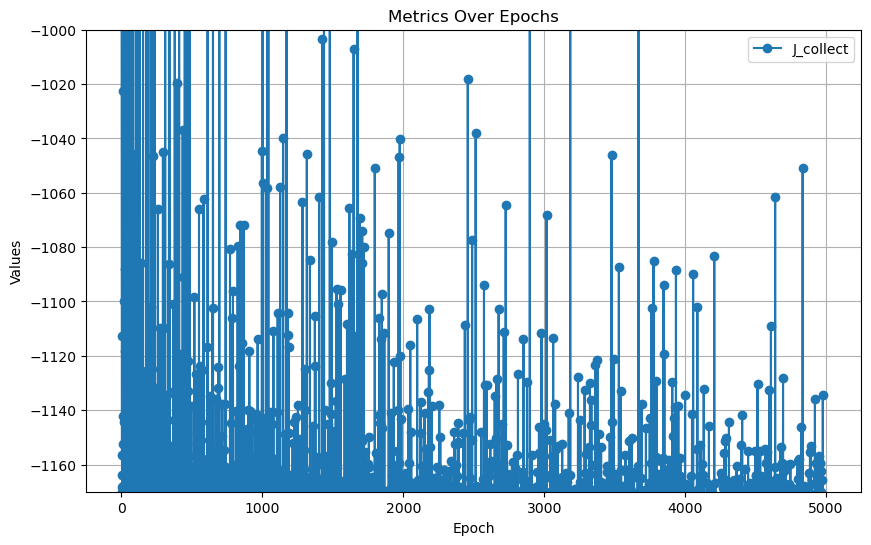

In [ ]:
# Plot
plt.figure(figsize=(10, 6))

epochs = range(1, EPOCH)  # Ensure EPOCH includes the last epoch

# Detach tensors and convert to NumPy
L_collect_np = [l.detach().numpy() for l in L_collect]
MSE_collect_np = [m.detach().numpy() for m in MSE_collect]

# Plot the metrics
plt.plot(epochs, J_collect, label='J_collect', marker='o')
# plt.plot(epochs, L_collect_np, label='L_collect', marker='s')
# plt.plot(epochs, MSE_collect_np, label='MSE_collect', marker='^')

# Add labels, legend, and grid
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.ylim(-1170, -1000)

# Show the plot
plt.show()

to generate y: tensor([[0.3257]], dtype=torch.float64)
real y: tensor([0.0328], grad_fn=<DivBackward0>)
regress y: tensor([[3.2752]], grad_fn=<TBackward0>)
y_mu: tensor([[3.2752]], grad_fn=<TBackward0>)
y_std: tensor([[8.9379e-06]], grad_fn=<TBackward0>)

to generate y: tensor([[0.3772]], dtype=torch.float64)
real y: tensor([0.0376], grad_fn=<DivBackward0>)
regress y: tensor([[3.7569]], grad_fn=<TBackward0>)
y_mu: tensor([[3.7569]], grad_fn=<TBackward0>)
y_std: tensor([[1.6919e-06]], grad_fn=<TBackward0>)

to generate y: tensor([[0.4287]], dtype=torch.float64)
real y: tensor([0.0427], grad_fn=<DivBackward0>)
regress y: tensor([[4.2738]], grad_fn=<TBackward0>)
y_mu: tensor([[4.2738]], grad_fn=<TBackward0>)
y_std: tensor([[2.8352e-07]], grad_fn=<TBackward0>)

to generate y: tensor([[0.4802]], dtype=torch.float64)
real y: tensor([0.0479], grad_fn=<DivBackward0>)
regress y: tensor([[4.7860]], grad_fn=<TBackward0>)
y_mu: tensor([[4.7860]], grad_fn=<TBackward0>)
y_std: tensor([[4.8229e-08]],

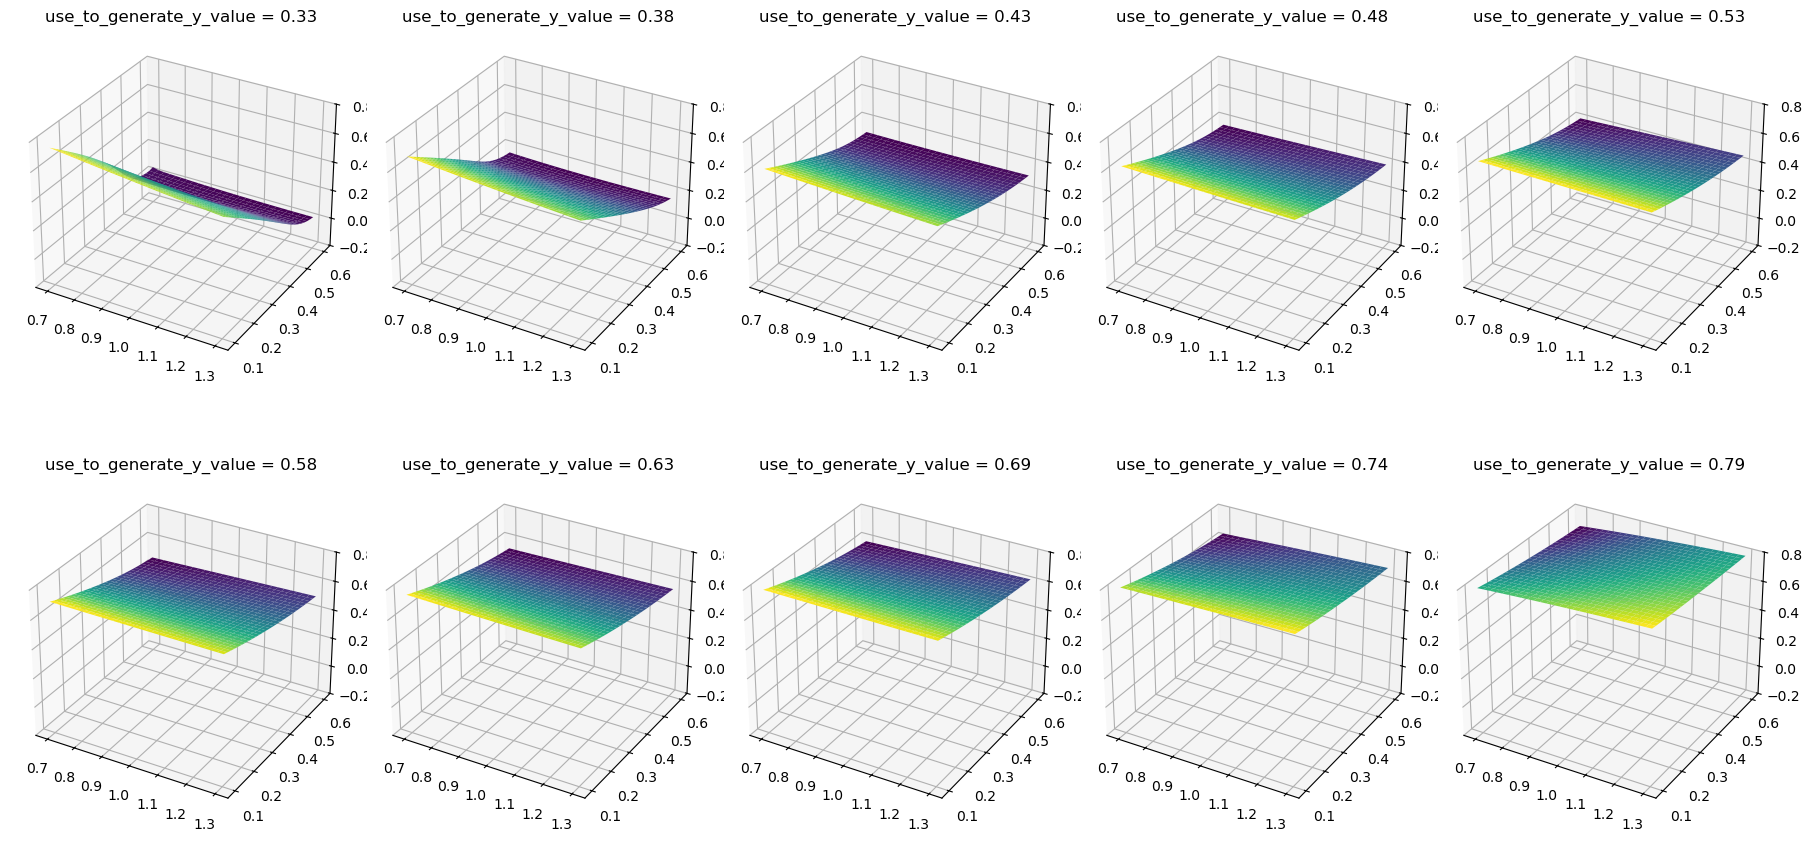

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
from torch.autograd import Variable

# Initialize the figure and 2x5 axes array
fig, axarr = plt.subplots(2, 5, figsize=(18, 10), subplot_kw={'projection': '3d'})

# Set the range for T and K
T = np.linspace(0.1, 0.6, 28)
K = np.linspace(0.7, 1.3, 28)
T, K = np.meshgrid(T, K)

y_values = np.linspace(level.min(), level.max(), 10)
z = Variable(torch.randn(1, z_dim))

model.eval()
for i, y_value in enumerate(y_values):
    # Set y to a specific value for each sample
    y = Variable(torch.tensor([y_value]).repeat(1, 1))
    print("to generate y:", y.t()/10)

    # Generate samples from the model
    x_mu = model.sample(z, y)
    print("real y:", x_mu.mean(dim=1).t()/10)
    print("regress y:", model.regress(x_mu)[0].t())
    print("y_mu:", model.regress(x_mu)[1].t())
    print("y_std:", model.regress(x_mu)[2].mul(0.5).exp_().t())
    print()
    samples = x_mu.data.view(-1, 1, 28, 28).numpy()

    # Determine subplot position (row, column)
    row, col = divmod(i, 5)
    ax = axarr[row, col]
    
    # Plot the surface
    surf = ax.plot_surface(K, T, samples[0, 0, :, :], cmap='viridis')

    # Set title and adjust z-axis limits for consistency
    ax.set_title("to generate y:", y.t()/10)
    ax.set_title("real y:", x_mu.mean(dim=1).t()/10)
    ax.set_title("regress y:", model.regress(x_mu)[0].t())
    ax.set_title("y_mu:", model.regress(x_mu)[1].t())
    ax.set_title("y_std:", model.regress(x_mu)[2].mul(0.5).exp_().t())
    ax.set_zlim(-0.2, 0.8)  # Adjust the z-axis limits to be consistent across all plots

# Show the final figure with all subplots
plt.tight_layout()
plt.show()


Real y: tensor([[0.7892, 0.7892, 0.7892, 0.7892, 0.7892, 0.7892, 0.7892, 0.7892, 0.7892,
         0.7892, 0.7892, 0.7892, 0.7892, 0.7892, 0.7892, 0.7892],
        [0.5451, 0.5451, 0.5451, 0.5451, 0.5451, 0.5451, 0.5451, 0.5451, 0.5451,
         0.5451, 0.5451, 0.5451, 0.5451, 0.5451, 0.5451, 0.5451],
        [0.0051, 0.0051, 0.0051, 0.0051, 0.0051, 0.0051, 0.0051, 0.0051, 0.0051,
         0.0051, 0.0051, 0.0051, 0.0051, 0.0051, 0.0051, 0.0051]],
       device='cuda:0')
Regressed y: tensor([[ 7.8840e-01,  7.8258e-01,  7.7937e-01,  7.8023e-01,  7.8572e-01,
          7.8482e-01,  7.8478e-01,  7.8415e-01,  7.8414e-01,  7.8386e-01,
          7.8620e-01,  7.8209e-01,  7.8869e-01,  7.8371e-01,  7.8184e-01,
          7.7891e-01],
        [ 6.6628e-01,  6.1642e-01,  5.7713e-01,  6.2144e-01,  6.1801e-01,
          6.0612e-01,  5.7426e-01,  6.1050e-01,  6.2689e-01,  5.9976e-01,
          7.0403e-01,  6.7778e-01,  6.9711e-01,  6.5862e-01,  5.5844e-01,
          4.5793e-01],
        [ 2.3757e-02,  

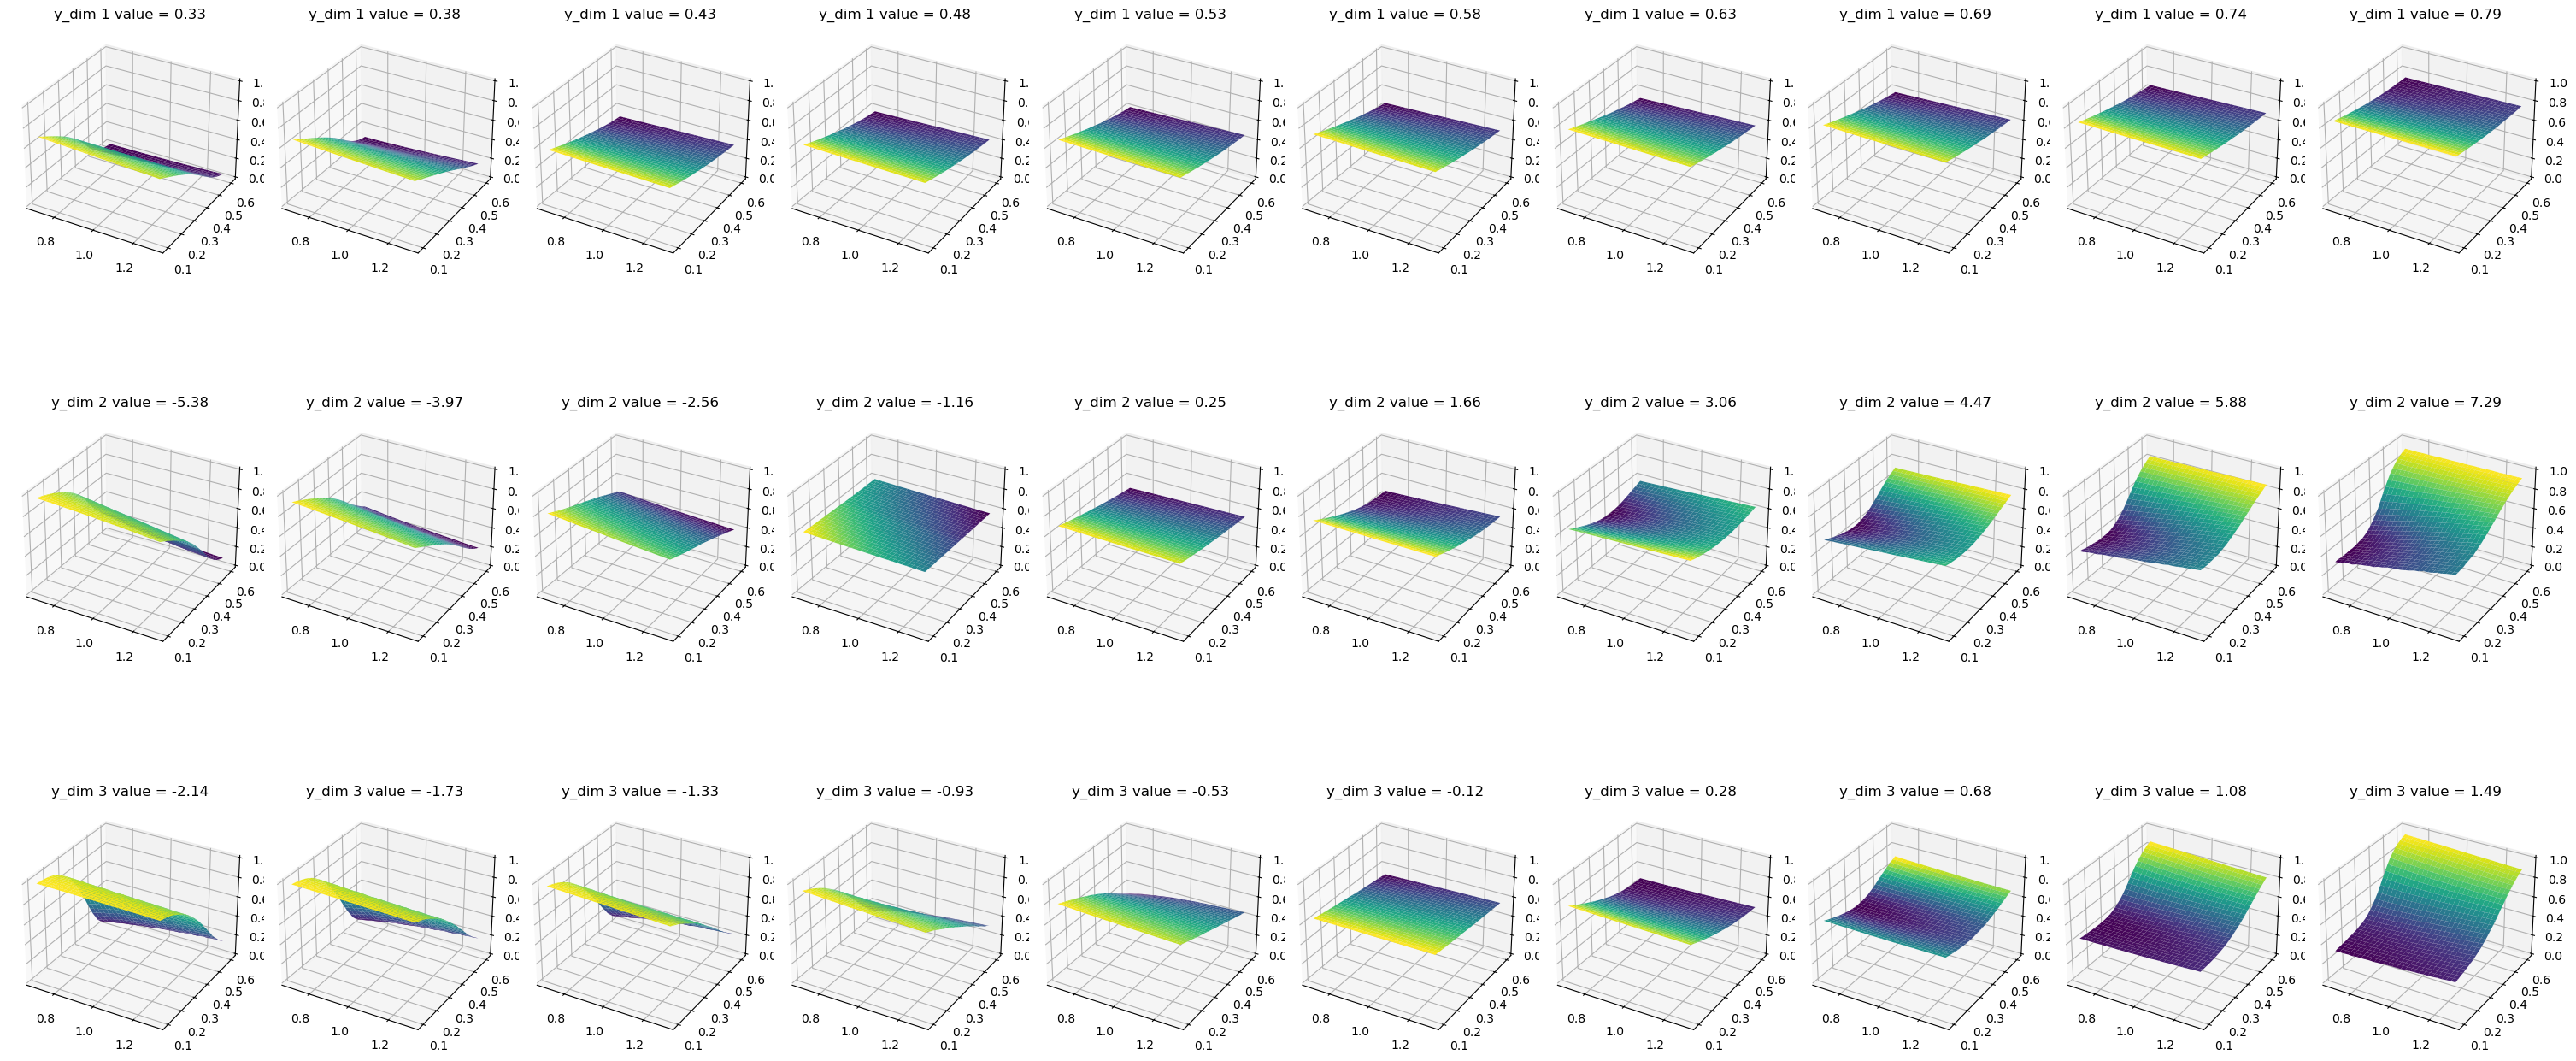

In [ ]:
# !3 lines

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np
# import torch
# from torch.autograd import Variable

# # Initialize figure and 2x5 axes array
# fig, axarr = plt.subplots(3, 10, figsize=(30, 15), subplot_kw={'projection': '3d'})

# # Set the range for T and K
# T = np.linspace(0.1, 0.6, 28)
# K = np.linspace(0.7, 1.3, 28)
# T, K = np.meshgrid(T, K)

# z = Variable(torch.randn(16, z_dim))
# if cuda:
#     z = z.cuda(device=0)

# model.eval()
# for dim in range(3):  # Loop over each dimension of the 3D y
#     level_min, level_max = level.min().item(), level.max().item()
#     y_min = tar[:, dim].min()
#     y_max = tar[:, dim].max()
#     y_values = np.linspace(y_min, y_max, 10)
#     for i, y_value in enumerate(y_values):
#         # Set y to a specific value for the current dimension, keep others fixed
#         y = Variable(torch.zeros(16, 3))  # Initialize y as a 3D tensor
#         y[:, 0] = tar[:, 0].mean()
#         y[:, 1] = tar[:, 1].mean()
#         y[:, 2] = tar[:, 2].mean()
#         y[:, dim] = y_value  # Set only the current dimension to y_value
#         if cuda:
#             y = y.cuda(device=0)

#         # Generate samples from the model
#         x_mu = model.sample(z, y)

#         samples = x_mu.data.view(-1, 1, 28, 28).cpu().numpy()

#         # Determine subplot position (row, column)
#         row = dim  # Row for the specific y dimension
#         col = i    # Column for the y_value within that dimension
#         ax = axarr[row, col]

#         # Plot the surface
#         surf = ax.plot_surface(K, T, samples[0, 0, :, :].t(), cmap='viridis')

#         # Set title and adjust z-axis limits for consistency
#         ax.set_title(f'y_dim {dim+1} value = {y_value:.2f}')
#         ax.set_zlim(0, 1)  # Adjust the z-axis limits to be consistent across all plots
        
#     print("Real y:", y.t())
#     print("Regressed y:", model.regress(x_mu)[0].t())
#     print("y_mu:", model.regress(x_mu)[1].t())
#     print("y_std:", model.regress(x_mu)[2].mul(0.5).exp_().t())
#     print()

# # Show the final figure with all subplots
# plt.tight_layout()
# plt.show()


In [ ]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

## Stacked Deep Generative Model

The M1+M2 model also described in the same paper is an M1 model (VAE) with an M2 model stacked on top of it. That means that we train the a VAE end-to-end on the data given dataset, then we use the learned encoder as a feature extractor and feed the data transformed by the M1 encoder into the M2 model.

We approach is somewhat similar to restricted boltzmann machines (RBMs) in the sense that we perform a layerwise training of the whole model by first training a level-1 feature extractor and stacking another model on top of this. The stacked model is therefore also more modular, but cannot be trained end-to-end, which is a downside.

In [ ]:
from models import VariationalAutoencoder, StackedDeepGenerativeModel

features = VariationalAutoencoder([784, z_dim, h_dim])
model = StackedDeepGenerativeModel([784, y_dim, z_dim, h_dim], features)

Typically, you would want to load a pretrained feature extractor VAE instead.

In [ ]:
features = torch.load("./your-pretrained-vae.pt")

C:\Users\jwang47\AppData\Local\Temp\ipykernel_15576\1198095296.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load("./your-pretrained-vae.pt")


FileNotFoundError: [Errno 2] No such file or directory: './your-pretrained-vae.pt'

In [ ]:
from torch.autograd import Variable

for epoch in range(10):
    model.train()
    total_loss, accuracy = (0, 0)
    for (x, y), (u, _) in zip(cycle(labelled), unlabelled):
        # Wrap in variables
        x, y, u = Variable(x), Variable(y), Variable(u)

        if cuda:
            # They need to be on the same device and be synchronized.
            x, y = x.cuda(device=0), y.cuda(device=0)
            u = u.cuda(device=0)

        L = -elbo(x, y)
        U = -elbo(u)

        # Add auxiliary classification loss q(y|x)
        logits = model.classify(x)
        
        # Regular cross entropy
        classication_loss = torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

        J_alpha = L - alpha * classication_loss + U

        J_alpha.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += J_alpha.data[0]
        accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())
        
    if epoch % 1 == 0:
        model.eval()
        m = len(unlabelled)
        print("Epoch: {}".format(epoch))
        print("[Train]\t\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))

        total_loss, accuracy = (0, 0)
        for x, y in validation:
            x, y = Variable(x), Variable(y)

            if cuda:
                x, y = x.cuda(device=0), y.cuda(device=0)

            L = -elbo(x, y)
            U = -elbo(x)

            logits = model.classify(x)
            classication_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

            J_alpha = L + alpha * classication_loss + U

            total_loss += J_alpha.data[0]

            _, pred_idx = torch.max(logits, 1)
            _, lab_idx = torch.max(y, 1)
            accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

        m = len(validation)
        print("[Validation]\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))

## Additional tips

You can change the built-in classifier with your own, for example if you want a CNN as a classifier you can do the following.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvolutionalClassifier(nn.Module):
    def __init__(self):
        super(ConvolutionalClassifier, self).__init__()        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=4)

        size = int((28 - 3) + 1)//4
        size = int((size - 3) + 1)//4
                
        self.fc1 = nn.Linear(32*size**2, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        batch, *_ = x.size()
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(x.view(batch, -1))
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x, dim=-1)

classifier = ConvolutionalClassifier()
model.classifier = classifier

In [ ]:
model

DeepGenerativeModel(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=794, out_features=256)
      (1): Linear(in_features=256, out_features=128)
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=128, out_features=32)
      (log_var): Linear(in_features=128, out_features=32)
    )
  )
  (decoder): Decoder(
    (hidden): ModuleList(
      (0): Linear(in_features=42, out_features=128)
      (1): Linear(in_features=128, out_features=256)
    )
    (reconstruction): Linear(in_features=256, out_features=784)
    (output_activation): Sigmoid()
  )
  (classifier): ConvolutionalClassifier(
    (conv1): Conv2d (1, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d (64, 32, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), dilation=(1, 1))
    (fc1): Linear(in_features=32, out_features=50)
    (fc2): Linear(in_features=50, out_features=10)
  )
)